In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import time

Symbols,MSFT,IBM,AAPL,GOOG
Date,,,,
2021-05-19,4.162759,1.050937,4.548510,2.936767
2021-05-20,4.220290,1.056001,4.644084,2.997036
2021-05-21,4.197860,1.062313,4.575504,2.983057
2021-05-24,4.293916,1.062166,4.636423,3.061376
2021-05-25,4.310011,1.055341,4.629128,3.064429


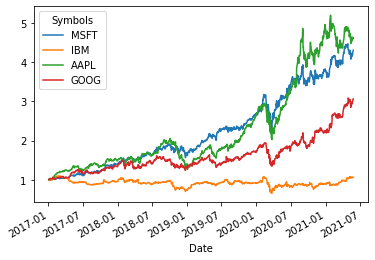

In [2]:
# load data 
stocks = DataReader(['MSFT', 'IBM', 'AAPL', 'GOOG'], 'yahoo', start=dt.datetime(2017,1,1),end=dt.datetime(2021,5,25))['Adj Close']
# plot normalized prices of these stocks
normalized_price = stocks / stocks.iloc[0,:]
normalized_price.plot()
normalized_price.tail()
# data.shape
# stocks.plot()

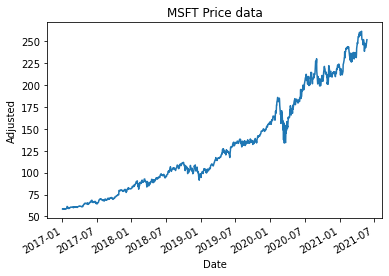

In [3]:
stocks['MSFT'].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted")
plt.title("MSFT Price data")
plt.show()

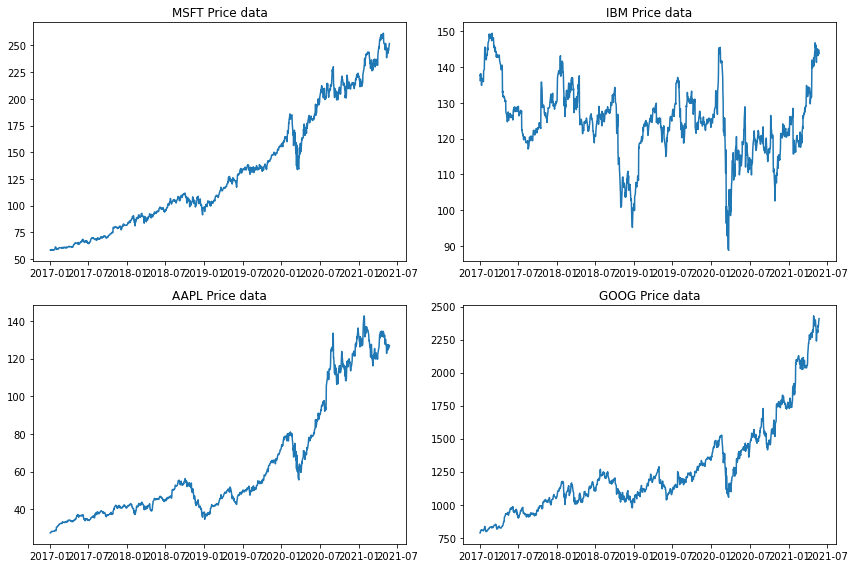

In [4]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.plot(stocks['MSFT'])
ax1.set_title("MSFT Price data")
ax2.plot(stocks['IBM'])
ax2.set_title("IBM Price data")
ax3.plot(stocks['AAPL'])
ax3.set_title("AAPL Price data")
ax4.plot(stocks['GOOG'])
ax4.set_title("GOOG Price data")
plt.tight_layout()
plt.show()

In [5]:
MSFT_daily_returns = stocks['MSFT'].pct_change().sum()
MSFT_monthly_returns = stocks['MSFT'].resample('M').ffill().pct_change()
print(MSFT_daily_returns)

1.6397253213106309


In [6]:
stocks.describe()

Symbols,MSFT,IBM,AAPL,GOOG
count,1106.000000,1106.000000,1106.000000,1106.000000
mean,131.704419,124.884073,63.349726,1260.381748
std,57.005517,10.005240,31.966140,349.785041
min,58.142242,88.795891,27.382690,786.140015
25%,86.622334,119.756485,40.623611,1039.482483
50%,113.403908,124.833046,49.595364,1164.280029
75%,177.502026,130.000252,78.222795,1416.349976
max,261.366486,149.450806,142.704010,2429.889893


In [7]:
data = stocks/stocks.shift(1) # pt/pt-1
data = data.dropna(how='all') # delete 'NaN'
x = data.to_numpy() # relative price
#data.info()
N=x.shape[0]
d=x.shape[1]
# x=np.zeros((N,d))
b=np.ones(d)/d
x

array([[0.99552552, 1.01238108, 0.99888078, 1.00096676],
       [1.        , 0.99669153, 1.00508546, 1.00904816],
       [1.00866783, 1.00491991, 1.01114819, 1.0152767 ],
       ...,
       [0.99468518, 1.00597721, 0.98523292, 0.9953355 ],
       [1.02288208, 0.99986179, 1.01331418, 1.02625467],
       [1.00374832, 0.99357374, 0.99842646, 1.00099729]])

In [8]:
def simplex_proj(y):
    """ Projection of y onto simplex. """
    m = len(y)
    bget = False
    s = sorted(y, reverse=True)
    tmpsum = 0.
    for ii in range(m-1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1);
        if tmax >= s[ii+1]:
            bget = True
            break
    if not bget:
        tmax = (tmpsum + s[m-1] -1)/m

    return np.maximum(y-tmax,0.)

In [9]:
start = time.time()
cum_ret=1 # Initialization
w=5 # Window size
#Inputs: w = window size, t = index of last trading day, x = Historical market sequence of returns (p / p_[t-1]), b_hat = current portfolio (at end of trading day t).  Initialize m to width of matrix x (= number of stocks)
b=1. / d * np.ones(data.shape)
daily_r=np.ones(N)
for t in range(N-1):
    # 1. Return the current portfolio ˆbt if t < 2w
    if t < 2*w - 1:
        b
    else:
    # 2.1 Compute LX1, LX2
        LX1 = np.log(x[t-2*w+1:t-w+1,:])
        LX2 = np.log(x[t-w+1:t+1,:])
    # 2.2 Compute averages of LX1 and LX2
        mu1 = np.mean(LX1, axis=0) 
        mu2 = np.mean(LX2, axis=0)
    # 3 Compute Mcor(i, j)
        M_cov = np.zeros((d,d))
        M_cor = np.zeros((d,d))
        claim = np.zeros((d,d))
        transfer = np.zeros((d,d))        
        sig1 = np.std(LX1, axis=0)
        sig2 = np.std(LX2, axis=0)
        sigma = sig1@sig2
        
    # 4-5
        for i in range(d):
            for j in range(d):
                M_cov[i,j] = np.dot(np.transpose(LX1[:,i]-mu1[i]),(LX2[:,j] - mu2[j]))/(w-1)
                # 3
                if (sigma == 0):
                    M_cor[i,j] = 0
                else:
                    M_cor[i,j] = M_cov[i,j] / sigma
                    
                if(i!=j):
                    if ((mu2[i] >= mu2[j]) & (M_cor[i,j] > 0)):
                        claim[i,j] = claim[i,j] + M_cor[i,j]
                        if (M_cor[i,i] < 0):
                            claim[i,j] = claim[i,j] + np.maximum(0, -M_cor[i,i])
                        if (M_cor[j,j] < 0):
                            claim[i,j] = claim[i,j] + np.maximum(0, -M_cor[j,j])
            
    # 6   
        for i in range(d):   
            total_claim = 0
            for j in range(d):
                total_claim += claim[i,j]
            if(total_claim != 0):
                for j in range(d):
                    transfer[i,j] = b[t,i] * claim[i,j] / total_claim
        
        for i in range(d): 
            b[t+1,i] = b[t,i]
            for j in range(d):
                # update weights    
                b[t+1,i] +=transfer[j,i] - transfer[i,j]

        b[t+1] = simplex_proj(b[t+1])
#     tc = gamma/2 * (np.abs(((x[t+1]*b)/ (np.dot(x[t+1],b)))[1:] - b[1:])).sum()
        daily_r[t] = np.dot(x[t+1],b[t+1]) #* (1-tc)
        cum_ret = cum_ret * daily_r[t] 
print("Cumulative return:",cum_ret,"-----> Expressed by scientific counting:",f'{cum_ret:1.2e}') 

end = time.time()
print("Program running time:",end-start)

Cumulative return: 2.738328445646424 -----> Expressed by scientific counting: 2.74e+00
Program running time: 0.653998851776123


Text(0.5, 1.0, 'Daily return Portfolio Value')

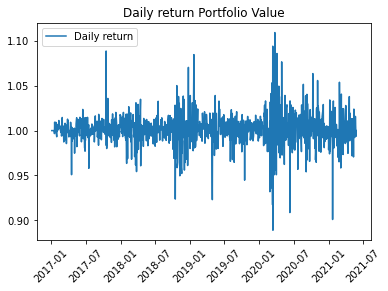

In [10]:
# A chart of daily return ratio over time
plt.plot(data.index,daily_r,label='Daily return')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title('Daily return Portfolio Value')

In [11]:
daily_r = pd.DataFrame(daily_r,index = data.index,columns=['daily return'])
# print(daily_r)
mean_daily = daily_r['daily return'].mean()
print("Average daily rate of return:",mean_daily)
mean_return_annualized = mean_daily**252 - 1
print("Annualized mean return ：", mean_return_annualized)

Average daily rate of return: 1.0010780727476247
Annualized mean return ： 0.3119676001636378


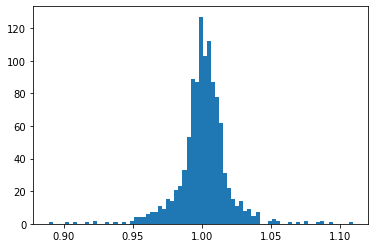

In [12]:
# A histogram of returns
plt.hist(np.array(daily_r), bins=75)
plt.show()

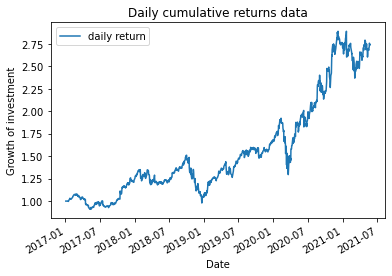

In [13]:
# This chart shows the cumulative returns since 2015 for four datasets.
cum_returns = daily_r.cumprod()
cum_returns.plot()
plt.xlabel("Date")
plt.ylabel("Growth of investment")
plt.title("Daily cumulative returns data")
plt.show()

In [14]:
std_daily = np.std(np.array(daily_r))
print("Daily rate return standard deviation: ", std_daily)
variance_daily = std_daily ** 2
print("Daily rate return variance: ", variance_daily)
std_annualized = std_daily*np.sqrt(252)
print("Annualized standard deviation：", std_annualized)
variance_annualized = std_annualized ** 2
print("Annualized variance：", variance_annualized)

Daily rate return standard deviation:  0.018204272947156465
Daily rate return variance:  0.00033139555353457273
Annualized standard deviation： 0.2889838741015013
Annualized variance： 0.08351167949071234


In [15]:
volatility = std_daily * np.sqrt(252)
print("Volatility is: ",volatility)
SR = mean_daily/std_daily
print("Daily Sharpe ratio is: ",SR)
ASR=np.sqrt(252)*SR
print("Annualized Sharpe ratio is: ",ASR)

Volatility is:  0.2889838741015013
Daily Sharpe ratio is:  54.99137898303127
Annualized Sharpe ratio is:  872.9610782496285


In [16]:
# Max Drawdown
maximum = np.maximum.accumulate(np.array(daily_r))
MDD = ((maximum - np.array(daily_r)) / maximum).max()
print("Max Drawdown is: ",MDD)
CS = mean_return_annualized/MDD
print("Calmar Ratio is: ",CS)
win_rate = np.sum(np.array(daily_r)>=1) / np.array(daily_r).size
print("Winning days rate: ",win_rate)


Max Drawdown is:  0.18774722586676815
Calmar Ratio is:  1.6616362703810104
Winning days rate:  0.5574660633484163


### Parameter sensitivity analysis

In [22]:
windows=np.arange(0,200,10)
cum_ret=np.ones(20) # Initialization
# w=5 # Window size
#Inputs: w = window size, t = index of last trading day, x = Historical market sequence of returns (p / p_[t-1]), b_hat = current portfolio (at end of trading day t).  Initialize m to width of matrix x (= number of stocks)
b=1. / d * np.ones(data.shape)
daily_r=np.ones(N)
for r in range(20):
    w = windows[r]
#     print(w)
    for t in range(N-1):
        # 1. Return the current portfolio ˆbt if t < 2w
        if t < 2*w - 1:
            b
        else:
        # 2.1 Compute LX1, LX2
            LX1 = np.log(x[t-2*w+1:t-w+1,:])
            LX2 = np.log(x[t-w+1:t+1,:])
        # 2.2 Compute averages of LX1 and LX2
            mu1 = np.mean(LX1, axis=0) 
            mu2 = np.mean(LX2, axis=0)
        # 3 Compute Mcor(i, j)
            M_cov = np.zeros((d,d))
            M_cor = np.zeros((d,d))
            claim = np.zeros((d,d))
            transfer = np.zeros((d,d))        
            sig1 = np.std(LX1, axis=0)
            sig2 = np.std(LX2, axis=0)
            sigma = sig1@sig2
        # 4-5
            for i in range(d):
                for j in range(d):
                    M_cov[i,j] = np.dot(np.transpose(LX1[:,i]-mu1[i]),(LX2[:,j] - mu2[j]))/(w-1)
                    # 3
                    if (sigma == 0):
                        M_cor[i,j] = 0
                    else:
                        M_cor[i,j] = M_cov[i,j] / sigma

                    if(i!=j):
                        if ((mu2[i] >= mu2[j]) & (M_cor[i,j] > 0)):
                            claim[i,j] = claim[i,j] + M_cor[i,j]
                            if (M_cor[i,i] < 0):
                                claim[i,j] = claim[i,j] + np.maximum(0, -M_cor[i,i])
                            if (M_cor[j,j] < 0):
                                claim[i,j] = claim[i,j] + np.maximum(0, -M_cor[j,j])
        # 6   
            for i in range(d):   
                total_claim = 0
                for j in range(d):
                    total_claim += claim[i,j]
                if(total_claim != 0):
                    for j in range(d):
                        transfer[i,j] = b[t,i] * claim[i,j] / total_claim
            for i in range(d): 
                b[t+1,i] = b[t,i]
                for j in range(d):
                    # update weights    
                    b[t+1,i] +=transfer[j,i] - transfer[i,j]
            b[t+1] = simplex_proj(b[t+1])
            daily_r[t] = np.dot(x[t+1],b[t+1]) #* (1-tc)
            cum_ret[r] = cum_ret[r] * daily_r[t] 
#     print("Cumulative return:",cum_ret[r])
print("Cumulative return wwww:",cum_ret) 


D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Cumulative return wwww: [2.9821036  2.61211127 2.45979608 2.18347748 3.66965367 2.4764107
 2.52738213 2.76058205 3.9984878  1.83585404 2.43367    1.79510284
 1.49488514 1.36083717 2.34883663 1.42378073 1.32335823 1.47776855
 1.18401653 1.6329014 ]


Text(0.5, 1.0, 'Daily return value with different window size')

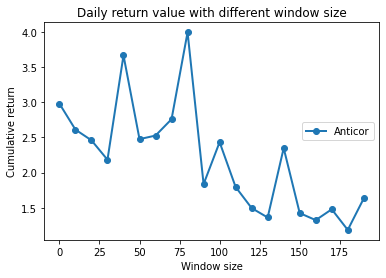

In [23]:
# A chart of daily return ratio over windows
plt.plot(windows,cum_ret,label='Anticor',linewidth=2,marker='o',markersize=6)
# plt.xticks(rotation=45)
# plt.xticks(np.arange(5,101,5))
plt.xlabel('Window size')
plt.ylabel('Cumulative return')

plt.legend(loc=5)
plt.title('Daily return value with different window size')